In [2]:
# importing libraries
import warnings
warnings.filterwarnings("ignore")
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
import datetime
from sklearn.model_selection import train_test_split
import re
import random

In [1]:
!wget --header="Host: dl.fbaipublicfiles.com" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/102.0.5005.63 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-US,en;q=0.9" --header="Referer: https://fasttext.cc/" "https://dl.fbaipublicfiles.com/fasttext/vectors-english/crawl-300d-2M.vec.zip" -c -O 'crawl-300d-2M.vec.zip'

--2022-06-14 06:17:13--  https://dl.fbaipublicfiles.com/fasttext/vectors-english/crawl-300d-2M.vec.zip
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.75.142, 172.67.9.4, 104.22.74.142, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.75.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1523785255 (1.4G) [application/zip]
Saving to: ‘crawl-300d-2M.vec.zip’

crawl-300d-2M.vec.z 100%[===================>]   1.42G  38.5MB/s    in 47s     

2022-06-14 06:18:00 (31.0 MB/s) - ‘crawl-300d-2M.vec.zip’ saved [1523785255/1523785255]



In [2]:
!unzip /content/crawl-300d-2M.vec.zip

Archive:  /content/crawl-300d-2M.vec.zip
  inflating: crawl-300d-2M.vec       


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!mv /content/crawl-300d-2M.vec /content/drive/MyDrive/

In [102]:
df = pd.read_csv('/content/drive/MyDrive/train-balanced-sarcasm.csv')
print('Shape of data is: ', df.shape)
df.head()

Shape of data is:  (1010826, 10)


,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,0,NC and NH.,Trumpbart,politics,2,-1,-1,2016-10,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ..."
1,0,You do know west teams play against west teams...,Shbshb906,nba,-4,-1,-1,2016-11,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...
2,0,"They were underdogs earlier today, but since G...",Creepeth,nfl,3,3,0,2016-09,2016-09-22 21:45:37,They're favored to win.
3,0,"This meme isn't funny none of the ""new york ni...",icebrotha,BlackPeopleTwitter,-8,-1,-1,2016-10,2016-10-18 21:03:47,deadass don't kill my buzz
4,0,I could use one of those tools.,cush2push,MaddenUltimateTeam,6,-1,-1,2016-12,2016-12-30 17:00:13,Yep can confirm I saw the tool they use for th...


In [103]:
df.dropna(inplace=True)
df.drop_duplicates(inplace=True)

# Featurization of date and created_utc

In [104]:
def date_to_numeric(data):
    dates = []
    for i in data['date']:
        i = datetime.datetime.strptime(i,"%Y-%m")
        i = i.timestamp()
        dates.append(i)
    data['date'] = dates
    return data

In [105]:
df = date_to_numeric(df)

In [106]:
def utc_to_numeric(data):
    dates = []
    for i in data['created_utc']:
        i = datetime.datetime.strptime(i,"%Y-%m-%d %H:%M:%S")
        i = i.timestamp()
        dates.append(i)
    data['created_utc'] = dates
    return data

In [107]:
df = utc_to_numeric(df)

In [108]:
# https://stackoverflow.com/questions/29432629/plot-correlation-matrix-using-pandas#:~:text=corr%20%3D%20df.corr()-,corr.style.background_gradient(cmap%3D%27coolwarm%27),-%23%20%27RdBu_r%27%2C%20%27BrBG_r%27%2C%20%26%20PuOr_r
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(4)

,label,score,ups,downs,date,created_utc
label,1.0000,-0.0100,-0.0067,0.0575,-0.0578,-0.0575
score,-0.0100,1.0000,0.8492,-0.0139,0.0169,0.0169
ups,-0.0067,0.8492,1.0000,0.0651,-0.0150,-0.0149
downs,0.0575,-0.0139,0.0651,1.0000,-0.4262,-0.4261
date,-0.0578,0.0169,-0.0150,-0.4262,1.0000,0.9998
created_utc,-0.0575,0.0169,-0.0149,-0.4261,0.9998,1.0000


#### date and created_utc are highly correlated and not very correlated to label. We can remove these features.

In [109]:
df.drop(['date', 'created_utc'], axis=1, inplace=True)

In [110]:
df.head()

,label,comment,author,subreddit,score,ups,downs,parent_comment
0,0,NC and NH.,Trumpbart,politics,2,-1,-1,"Yeah, I get that argument. At this point, I'd ..."
1,0,You do know west teams play against west teams...,Shbshb906,nba,-4,-1,-1,The blazers and Mavericks (The wests 5 and 6 s...
2,0,"They were underdogs earlier today, but since G...",Creepeth,nfl,3,3,0,They're favored to win.
3,0,"This meme isn't funny none of the ""new york ni...",icebrotha,BlackPeopleTwitter,-8,-1,-1,deadass don't kill my buzz
4,0,I could use one of those tools.,cush2push,MaddenUltimateTeam,6,-1,-1,Yep can confirm I saw the tool they use for th...


# Data cleaning

## Cleaning text feature: Comment

In [111]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [112]:
# https://stackoverflow.com/a/47091490/4084039
from nltk.corpus import stopwords
stopwords = stopwords.words('english')

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

# https://gist.github.com/sebleier/554280

# Remove Emoji
def deEmojify(text):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'',text)

def preprocess_text(text_data):
    preprocessed_text = []
    # tqdm is for printing the status bar
    for sentance in tqdm(text_data):
        sent = decontracted(sentance)
        sent=deEmojify(sent)
        sent = sent.replace('\\r', ' ')
        sent = sent.replace('\\n', ' ')
        sent = sent.replace('\\"', ' ')
        sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
        # https://gist.github.com/sebleier/554280
        sent = ' '.join(e for e in sent.split() if e not in stopwords)
        preprocessed_text.append(sent.lower().strip())
    return preprocessed_text

In [113]:
preprocessed_comments = preprocess_text(df['comment'].values)

100%|██████████| 1010745/1010745 [00:53<00:00, 18826.83it/s]


In [114]:
preprocessed_comments = preprocess_text(df['comment'].values)
df['preprocessed_comments'] = preprocessed_comments

In [115]:
# printing a few comments
print(df['comment'][100])
print(df['comment'][1000])
print(df['comment'][10000])
print(df['comment'][100000])

I couldn't even breathe for a few seconds after reading this because I was laughing so hard.
But... but... from out of the sewers comes... Elo.
It's easy to get confused given that there are so many popular Buddhist temples in Malaysia with all the hilltribe kids hanging around.
I still don't understand you.


In [116]:
# printing a few preprocessed comments
print(df['preprocessed_comments'][100])
print(df['preprocessed_comments'][1000])
print(df['preprocessed_comments'][10000])
print(df['preprocessed_comments'][100000])

i could even breathe seconds reading i laughing hard
but sewers comes elo
it easy get confused given many popular buddhist temples malaysia hilltribe kids hanging around
i still understand


## Cleaning text feature: Parent Comment

In [117]:
preprocessed_pcomments = preprocess_text(df['parent_comment'].values)

100%|██████████| 1010745/1010745 [02:25<00:00, 6943.75it/s]


In [118]:
preprocessed_pcomments = preprocess_text(df['parent_comment'].values)
df['preprocessed_pcomments'] = preprocessed_pcomments

In [119]:
# printing a few parent comments
print(df['parent_comment'][100])
print(df['parent_comment'][1000])
print(df['parent_comment'][10000])
print(df['parent_comment'][100000])

How does Yui learn guitar so fast? She can barely breathe without Ui's help.
Meta picks in higher ranks grant you a higher chance of winning. Don't pick this twitch jungle when you have olaf/lee free and your team has no tank.
Going by OP's comments, he clearly isn't the brightest bulb in the box either. Apparently he originally said that the watch went missing in Malaysia until someone pointed out that Wat Doi Suthep is in Thailand.
It can't be both. Either it doesn't matter to the majority who have high pressure jobs or its an invasion that violated fair elections. Either it was nothing or it was something. Either way the source is hillarys campaign as they were corrupt.


In [120]:
# printing a few preprocessed parent comments
print(df['preprocessed_pcomments'][100])
print(df['preprocessed_pcomments'][1000])
print(df['preprocessed_pcomments'][10000])
print(df['preprocessed_pcomments'][100000])

how yui learn guitar fast she barely breathe without ui help
meta picks higher ranks grant higher chance winning do pick twitch jungle olaf lee free team tank
going op comments clearly brightest bulb box either apparently originally said watch went missing malaysia someone pointed wat doi suthep thailand
it either matter majority high pressure jobs invasion violated fair elections either nothing something either way source hillarys campaign corrupt


In [121]:
df.drop(['comment', 'parent_comment'], axis=1, inplace=True)

In [122]:
df.head()

,label,author,subreddit,score,ups,downs,preprocessed_comments,preprocessed_pcomments
0,0,Trumpbart,politics,2,-1,-1,nc nh,yeah i get argument at point i would prefer li...
1,0,Shbshb906,nba,-4,-1,-1,you know west teams play west teams east teams...,the blazers mavericks the wests 5 6 seed even ...
2,0,Creepeth,nfl,3,3,0,they underdogs earlier today since gronk annou...,they favored win
3,0,icebrotha,BlackPeopleTwitter,-8,-1,-1,this meme funny none new york nigga ones,deadass kill buzz
4,0,cush2push,MaddenUltimateTeam,6,-1,-1,i could use one tools,yep confirm i saw tool use it made boy easport...


In [123]:
df.isnull().sum()

label                     0
author                    0
subreddit                 0
score                     0
ups                       0
downs                     0
preprocessed_comments     0
preprocessed_pcomments    0
dtype: int64

In [124]:
df.dropna(inplace=True)

In [125]:
df.isnull().sum()

label                     0
author                    0
subreddit                 0
score                     0
ups                       0
downs                     0
preprocessed_comments     0
preprocessed_pcomments    0
dtype: int64

In [126]:
df.shape

(1010745, 8)

## Cleaning text feature: author

In [127]:
print(df['author'][10])
print(df['author'][100])
print(df['author'][1000])
print(df['author'][10000])
print(df['author'][100000])

ThisIsNotKimJongUn
impulsedragon
Teikanmi
MinisterOf
LeMot-Juste


In [128]:
df['author'] = df['author'].str.replace(' ','')
df['author'] = df['author'].str.replace('-','_')
df['author'] = df['author'].str.lower()

In [129]:
print(df['author'][10])
print(df['author'][100])
print(df['author'][1000])
print(df['author'][10000])
print(df['author'][100000])

thisisnotkimjongun
impulsedragon
teikanmi
ministerof
lemot_juste


## Cleaning text feature: subreddit

In [130]:
print(df['subreddit'][10])
print(df['subreddit'][100])
print(df['subreddit'][1000])
print(df['subreddit'][10000])
print(df['subreddit'][100000])

politics
anime
leagueoflegends
Thailand
worldnews


In [131]:
df['subreddit'] = df['subreddit'].str.replace(' ','')
df['subreddit'] = df['subreddit'].str.replace('-','_')
df['subreddit'] = df['subreddit'].str.lower()

In [132]:
print(df['subreddit'][10])
print(df['subreddit'][100])
print(df['subreddit'][1000])
print(df['subreddit'][10000])
print(df['subreddit'][100000])

politics
anime
leagueoflegends
thailand
worldnews


In [133]:
df.head()

,label,author,subreddit,score,ups,downs,preprocessed_comments,preprocessed_pcomments
0,0,trumpbart,politics,2,-1,-1,nc nh,yeah i get argument at point i would prefer li...
1,0,shbshb906,nba,-4,-1,-1,you know west teams play west teams east teams...,the blazers mavericks the wests 5 6 seed even ...
2,0,creepeth,nfl,3,3,0,they underdogs earlier today since gronk annou...,they favored win
3,0,icebrotha,blackpeopletwitter,-8,-1,-1,this meme funny none new york nigga ones,deadass kill buzz
4,0,cush2push,maddenultimateteam,6,-1,-1,i could use one tools,yep confirm i saw tool use it made boy easport...


# Featurization

## 1. Sentiment intensity

In [134]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [135]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Creating sentiment intensities on comment features
neg_comment = []
neu_comment = []
pos_comment = []
comp_comment = []

sid = SentimentIntensityAnalyzer()

for sentence in tqdm(df['preprocessed_comments']):
    ss = sid.polarity_scores(sentence)
    neg_comment.append(ss['neg'])
    neu_comment.append(ss['neu'])
    pos_comment.append(ss['pos'])
    comp_comment.append(ss['compound'])

df['Neg_comment'] = neg_comment
df['Neu_comment'] = neu_comment
df['Pos_comment'] = pos_comment
df['Compound_comment'] = comp_comment

100%|██████████| 1010745/1010745 [02:01<00:00, 8344.87it/s]


In [136]:
# Creating sentiment intensities on parent comment features
neg_pcomment = []
neu_pcomment = []
pos_pcomment = []
comp_pcomment = []

sid = SentimentIntensityAnalyzer()

for sentence in tqdm(df['preprocessed_pcomments']):
    ss = sid.polarity_scores(sentence)
    neg_pcomment.append(ss['neg'])
    neu_pcomment.append(ss['neu'])
    pos_pcomment.append(ss['pos'])
    comp_pcomment.append(ss['compound'])

df['Neg_pcomment'] = neg_pcomment
df['Neu_pcomment'] = neu_pcomment
df['Pos_pcomment'] = pos_pcomment
df['Compound_pcomment'] = comp_pcomment

100%|██████████| 1010745/1010745 [04:00<00:00, 4210.41it/s]


In [137]:
df.head()

,label,author,subreddit,score,ups,downs,preprocessed_comments,preprocessed_pcomments,Neg_comment,Neu_comment,Pos_comment,Compound_comment,Neg_pcomment,Neu_pcomment,Pos_pcomment,Compound_pcomment
0,0,trumpbart,politics,2,-1,-1,nc nh,yeah i get argument at point i would prefer li...,0.0,0.238,0.762,0.4939,0.181,0.507,0.312,0.2023
1,0,shbshb906,nba,-4,-1,-1,you know west teams play west teams east teams...,the blazers mavericks the wests 5 6 seed even ...,0.0,0.789,0.211,0.3400,0.000,0.838,0.162,0.4404
2,0,creepeth,nfl,3,3,0,they underdogs earlier today since gronk annou...,they favored win,0.0,1.000,0.000,0.0000,0.000,0.132,0.868,0.7650
3,0,icebrotha,blackpeopletwitter,-8,-1,-1,this meme funny none new york nigga ones,deadass kill buzz,0.0,0.707,0.293,0.4404,0.701,0.299,0.000,-0.6908
4,0,cush2push,maddenultimateteam,6,-1,-1,i could use one tools,yep confirm i saw tool use it made boy easport...,0.0,1.000,0.000,0.0000,0.000,0.804,0.196,0.2960


In [138]:
df.isnull().sum()

label                     0
author                    0
subreddit                 0
score                     0
ups                       0
downs                     0
preprocessed_comments     0
preprocessed_pcomments    0
Neg_comment               0
Neu_comment               0
Pos_comment               0
Compound_comment          0
Neg_pcomment              0
Neu_pcomment              0
Pos_pcomment              0
Compound_pcomment         0
dtype: int64

## 2. Length of sentences

In [139]:
df['comment_len']=df['preprocessed_comments'].apply(lambda x:len(x.split()))
df['pcomment_len']=df['preprocessed_pcomments'].apply(lambda x:len(x.split()))

In [140]:
df.head()

,label,author,subreddit,score,ups,downs,preprocessed_comments,preprocessed_pcomments,Neg_comment,Neu_comment,Pos_comment,Compound_comment,Neg_pcomment,Neu_pcomment,Pos_pcomment,Compound_pcomment,comment_len,pcomment_len
0,0,trumpbart,politics,2,-1,-1,nc nh,yeah i get argument at point i would prefer li...,0.0,0.238,0.762,0.4939,0.181,0.507,0.312,0.2023,2,12
1,0,shbshb906,nba,-4,-1,-1,you know west teams play west teams east teams...,the blazers mavericks the wests 5 6 seed even ...,0.0,0.789,0.211,0.3400,0.000,0.838,0.162,0.4404,10,18
2,0,creepeth,nfl,3,3,0,they underdogs earlier today since gronk annou...,they favored win,0.0,1.000,0.000,0.0000,0.000,0.132,0.868,0.7650,13,3
3,0,icebrotha,blackpeopletwitter,-8,-1,-1,this meme funny none new york nigga ones,deadass kill buzz,0.0,0.707,0.293,0.4404,0.701,0.299,0.000,-0.6908,8,3
4,0,cush2push,maddenultimateteam,6,-1,-1,i could use one tools,yep confirm i saw tool use it made boy easport...,0.0,1.000,0.000,0.0000,0.000,0.804,0.196,0.2960,5,11


In [141]:
df.head()

,label,author,subreddit,score,ups,downs,preprocessed_comments,preprocessed_pcomments,Neg_comment,Neu_comment,Pos_comment,Compound_comment,Neg_pcomment,Neu_pcomment,Pos_pcomment,Compound_pcomment,comment_len,pcomment_len
0,0,trumpbart,politics,2,-1,-1,nc nh,yeah i get argument at point i would prefer li...,0.0,0.238,0.762,0.4939,0.181,0.507,0.312,0.2023,2,12
1,0,shbshb906,nba,-4,-1,-1,you know west teams play west teams east teams...,the blazers mavericks the wests 5 6 seed even ...,0.0,0.789,0.211,0.3400,0.000,0.838,0.162,0.4404,10,18
2,0,creepeth,nfl,3,3,0,they underdogs earlier today since gronk annou...,they favored win,0.0,1.000,0.000,0.0000,0.000,0.132,0.868,0.7650,13,3
3,0,icebrotha,blackpeopletwitter,-8,-1,-1,this meme funny none new york nigga ones,deadass kill buzz,0.0,0.707,0.293,0.4404,0.701,0.299,0.000,-0.6908,8,3
4,0,cush2push,maddenultimateteam,6,-1,-1,i could use one tools,yep confirm i saw tool use it made boy easport...,0.0,1.000,0.000,0.0000,0.000,0.804,0.196,0.2960,5,11


In [142]:
df.to_csv('/content/drive/MyDrive/cleaned_data.csv', index=False)

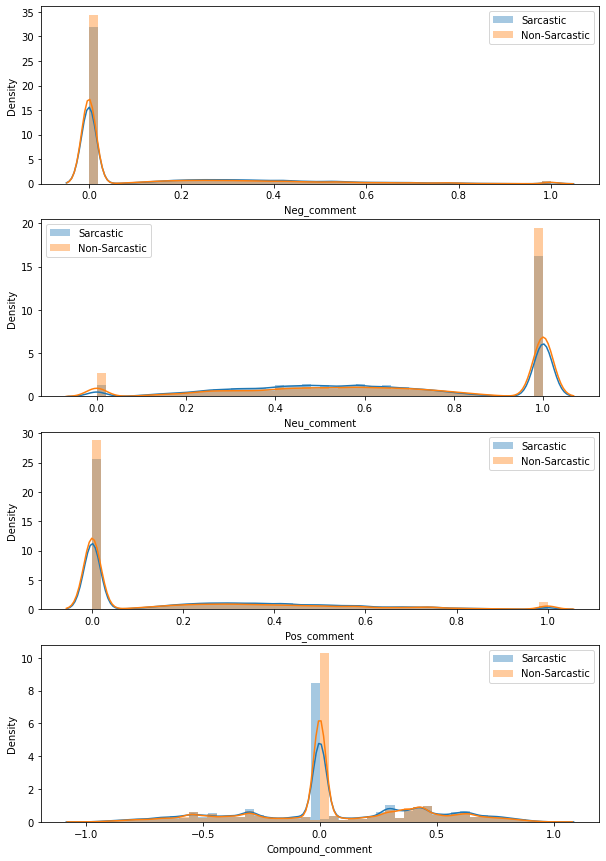

In [ ]:
df1 = df[df['label']==1]
df2 = df[df['label']==0]

plt.figure(figsize=(10,15))
plt.subplot(411)
sns.distplot(df1['Neg_comment'], label='Sarcastic')
sns.distplot(df2['Neg_comment'], label='Non-Sarcastic')
plt.legend()
plt.subplot(412)
sns.distplot(df1['Neu_comment'], label='Sarcastic')
sns.distplot(df2['Neu_comment'], label='Non-Sarcastic')
plt.legend()
plt.subplot(413)
sns.distplot(df1['Pos_comment'], label='Sarcastic')
sns.distplot(df2['Pos_comment'], label='Non-Sarcastic')
plt.legend()
plt.subplot(414)
sns.distplot(df1['Compound_comment'], label='Sarcastic')
sns.distplot(df2['Compound_comment'], label='Non-Sarcastic')
plt.legend()
plt.show()

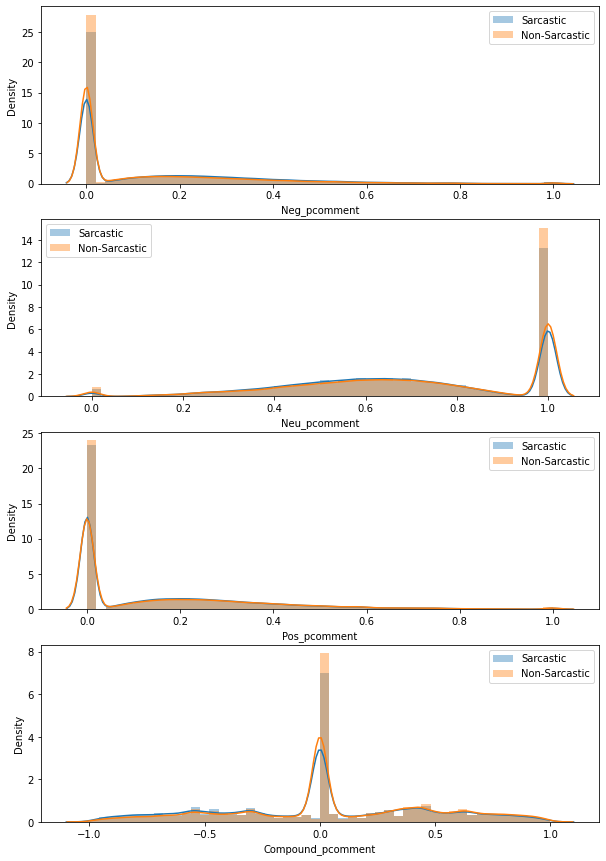

In [ ]:
plt.figure(figsize=(10,15))
plt.subplot(411)
sns.distplot(df1['Neg_pcomment'], label='Sarcastic')
sns.distplot(df2['Neg_pcomment'], label='Non-Sarcastic')
plt.legend()
plt.subplot(412)
sns.distplot(df1['Neu_pcomment'], label='Sarcastic')
sns.distplot(df2['Neu_pcomment'], label='Non-Sarcastic')
plt.legend()
plt.subplot(413)
sns.distplot(df1['Pos_pcomment'], label='Sarcastic')
sns.distplot(df2['Pos_pcomment'], label='Non-Sarcastic')
plt.legend()
plt.subplot(414)
sns.distplot(df1['Compound_pcomment'], label='Sarcastic')
sns.distplot(df2['Compound_pcomment'], label='Non-Sarcastic')
plt.legend()
plt.show()

# Data Preprocessing

In [4]:
df = pd.read_csv('cleaned_data.csv')

In [5]:
df.head()

,label,author,subreddit,score,ups,downs,preprocessed_comments,preprocessed_pcomments,Neg_comment,Neu_comment,Pos_comment,Compound_comment,Neg_pcomment,Neu_pcomment,Pos_pcomment,Compound_pcomment,comment_len,pcomment_len
0,0,trumpbart,politics,2,-1,-1,nc and nh,yeah i get that argument at this point i would...,0.000,0.385,0.615,0.4939,0.126,0.657,0.217,0.2023,3,18
1,0,shbshb906,nba,-4,-1,-1,you do know west teams play against west teams...,the blazers and mavericks the wests 5 and 6 se...,0.000,0.844,0.156,0.3400,0.095,0.905,0.000,-0.3412,14,27
2,0,creepeth,nfl,3,3,0,they were underdogs earlier today but since gr...,they are favored to win,0.000,1.000,0.000,0.0000,0.000,0.312,0.688,0.7650,20,5
3,0,icebrotha,blackpeopletwitter,-8,-1,-1,this meme is not funny none of the new york ni...,deadass do not kill my buzz,0.167,0.833,0.000,-0.3412,0.000,0.572,0.428,0.5773,13,6
4,0,cush2push,maddenultimateteam,6,-1,-1,i could use one of those tools,yep can confirm i saw the tool they use for th...,0.000,1.000,0.000,0.0000,0.000,0.885,0.115,0.2960,7,19


In [6]:
df.dropna(inplace=True)

In [7]:
df.isnull().sum()

label                     0
author                    0
subreddit                 0
score                     0
ups                       0
downs                     0
preprocessed_comments     0
preprocessed_pcomments    0
Neg_comment               0
Neu_comment               0
Pos_comment               0
Compound_comment          0
Neg_pcomment              0
Neu_pcomment              0
Pos_pcomment              0
Compound_pcomment         0
comment_len               0
pcomment_len              0
dtype: int64

In [8]:
df.shape

(1009323, 18)

## train test split

In [9]:
y = df['label']
X = df.drop('label', axis=1)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

In [11]:
print(X_train.shape)
print(y_train.shape)
print(X_cv.shape)
print(y_cv.shape)
print(X_test.shape)
print(y_test.shape)

(605593, 17)
(605593,)
(201865, 17)
(201865,)
(201865, 17)
(201865,)


## Encoding Author

In [12]:
from category_encoders.cat_boost import CatBoostEncoder

In [13]:
cat_author = CatBoostEncoder()

cat_author.fit(X_train['author'], y_train)

X_train['author'] = cat_author.transform(X_train['author'])
X_cv['author'] = cat_author.transform(X_cv['author'])
X_test['author'] = cat_author.transform(X_test['author'])

## Encoding subreddit

In [14]:
cat_subreddit = CatBoostEncoder()

cat_subreddit.fit(X_train['subreddit'], y_train)

X_train['subreddit'] = cat_subreddit.transform(X_train['subreddit'])
X_cv['subreddit'] = cat_subreddit.transform(X_cv['subreddit'])
X_test['subreddit'] = cat_subreddit.transform(X_test['subreddit'])

In [15]:
X_train.head()

,author,subreddit,score,ups,downs,preprocessed_comments,preprocessed_pcomments,Neg_comment,Neu_comment,Pos_comment,Compound_comment,Neg_pcomment,Neu_pcomment,Pos_pcomment,Compound_pcomment,comment_len,pcomment_len
753023,0.562478,0.586235,1,1,0,think it is pretty obvious the clowns behaving...,please remember to not be assholes to retail w...,0.000,0.749,0.251,0.6908,0.085,0.831,0.084,-0.6266,19,170
898182,0.374957,0.545383,1,1,0,too good and too consistent as well if they be...,except when ibp vs any other na teams they lit...,0.000,0.773,0.227,0.6124,0.000,0.818,0.182,0.4404,19,14
628795,0.499942,0.430672,1,1,0,life in prison too,what 45 gets you in tokyo,0.524,0.476,0.000,-0.5106,0.000,1.000,0.000,0.0000,4,6
986397,0.499942,0.485212,0,0,0,read the subreddit rules,my english teacher gave me some great advice,0.000,1.000,0.000,0.0000,0.000,0.631,0.369,0.6249,4,8
541351,0.499942,0.166609,1,1,0,pls respond,what is this from,0.000,0.435,0.565,0.0772,0.000,1.000,0.000,0.0000,2,4


In [16]:
pickle.dump((cat_author, cat_subreddit),open('cat.pkl','wb'))

## Scaling numerical feature: score

In [17]:
from sklearn.preprocessing import MinMaxScaler

In [18]:
scaler_score = MinMaxScaler()

scaler_score.fit(X_train['score'].values.reshape(-1,1))

X_train['score'] = scaler_score.transform(X_train['score'].values.reshape(-1,1))
X_cv['score'] = scaler_score.transform(X_cv['score'].values.reshape(-1,1))
X_test['score'] = scaler_score.transform(X_test['score'].values.reshape(-1,1))

In [19]:
X_train.head()

,author,subreddit,score,ups,downs,preprocessed_comments,preprocessed_pcomments,Neg_comment,Neu_comment,Pos_comment,Compound_comment,Neg_pcomment,Neu_pcomment,Pos_pcomment,Compound_pcomment,comment_len,pcomment_len
753023,0.562478,0.586235,0.053044,1,0,think it is pretty obvious the clowns behaving...,please remember to not be assholes to retail w...,0.000,0.749,0.251,0.6908,0.085,0.831,0.084,-0.6266,19,170
898182,0.374957,0.545383,0.053044,1,0,too good and too consistent as well if they be...,except when ibp vs any other na teams they lit...,0.000,0.773,0.227,0.6124,0.000,0.818,0.182,0.4404,19,14
628795,0.499942,0.430672,0.053044,1,0,life in prison too,what 45 gets you in tokyo,0.524,0.476,0.000,-0.5106,0.000,1.000,0.000,0.0000,4,6
986397,0.499942,0.485212,0.052939,0,0,read the subreddit rules,my english teacher gave me some great advice,0.000,1.000,0.000,0.0000,0.000,0.631,0.369,0.6249,4,8
541351,0.499942,0.166609,0.053044,1,0,pls respond,what is this from,0.000,0.435,0.565,0.0772,0.000,1.000,0.000,0.0000,2,4


## Scaling numerical feature: ups

In [20]:
scaler_ups = MinMaxScaler()

scaler_ups.fit(X_train['ups'].values.reshape(-1,1))

X_train['ups'] = scaler_ups.transform(X_train['ups'].values.reshape(-1,1))
X_cv['ups'] = scaler_ups.transform(X_cv['ups'].values.reshape(-1,1))
X_test['ups'] = scaler_ups.transform(X_test['ups'].values.reshape(-1,1))

In [21]:
X_train.head()

,author,subreddit,score,ups,downs,preprocessed_comments,preprocessed_pcomments,Neg_comment,Neu_comment,Pos_comment,Compound_comment,Neg_pcomment,Neu_pcomment,Pos_pcomment,Compound_pcomment,comment_len,pcomment_len
753023,0.562478,0.586235,0.053044,0.089594,0,think it is pretty obvious the clowns behaving...,please remember to not be assholes to retail w...,0.000,0.749,0.251,0.6908,0.085,0.831,0.084,-0.6266,19,170
898182,0.374957,0.545383,0.053044,0.089594,0,too good and too consistent as well if they be...,except when ibp vs any other na teams they lit...,0.000,0.773,0.227,0.6124,0.000,0.818,0.182,0.4404,19,14
628795,0.499942,0.430672,0.053044,0.089594,0,life in prison too,what 45 gets you in tokyo,0.524,0.476,0.000,-0.5106,0.000,1.000,0.000,0.0000,4,6
986397,0.499942,0.485212,0.052939,0.089418,0,read the subreddit rules,my english teacher gave me some great advice,0.000,1.000,0.000,0.0000,0.000,0.631,0.369,0.6249,4,8
541351,0.499942,0.166609,0.053044,0.089594,0,pls respond,what is this from,0.000,0.435,0.565,0.0772,0.000,1.000,0.000,0.0000,2,4


## Scaling numerical feature: Neg_comment

In [22]:
scaler_negc = MinMaxScaler()

scaler_negc.fit(X_train['Neg_comment'].values.reshape(-1,1))

X_train['Neg_comment'] = scaler_negc.transform(X_train['Neg_comment'].values.reshape(-1,1))
X_cv['Neg_comment'] = scaler_negc.transform(X_cv['Neg_comment'].values.reshape(-1,1))
X_test['Neg_comment'] = scaler_negc.transform(X_test['Neg_comment'].values.reshape(-1,1))

## Scaling numerical feature: Neu_comment

In [23]:
scaler_neuc = MinMaxScaler()

scaler_neuc.fit(X_train['Neu_comment'].values.reshape(-1,1))

X_train['Neu_comment'] = scaler_neuc.transform(X_train['Neu_comment'].values.reshape(-1,1))
X_cv['Neu_comment'] = scaler_neuc.transform(X_cv['Neu_comment'].values.reshape(-1,1))
X_test['Neu_comment'] = scaler_neuc.transform(X_test['Neu_comment'].values.reshape(-1,1))

## Scaling numerical feature: Pos_comment

In [24]:
scaler_posc = MinMaxScaler()

scaler_posc.fit(X_train['Pos_comment'].values.reshape(-1,1))

X_train['Pos_comment'] = scaler_posc.transform(X_train['Pos_comment'].values.reshape(-1,1))
X_cv['Pos_comment'] = scaler_posc.transform(X_cv['Pos_comment'].values.reshape(-1,1))
X_test['Pos_comment'] = scaler_posc.transform(X_test['Pos_comment'].values.reshape(-1,1))

## Scaling numerical feature: Compound_comment

In [25]:
scaler_compc = MinMaxScaler()

scaler_compc.fit(X_train['Compound_comment'].values.reshape(-1,1))

X_train['Compound_comment'] = scaler_compc.transform(X_train['Compound_comment'].values.reshape(-1,1))
X_cv['Compound_comment'] = scaler_compc.transform(X_cv['Compound_comment'].values.reshape(-1,1))
X_test['Compound_comment'] = scaler_compc.transform(X_test['Compound_comment'].values.reshape(-1,1))

## Scaling numerical feature: Neg_pcomment

In [26]:
scaler_negpc = MinMaxScaler()

scaler_negpc.fit(X_train['Neg_pcomment'].values.reshape(-1,1))

X_train['Neg_pcomment'] = scaler_negpc.transform(X_train['Neg_pcomment'].values.reshape(-1,1))
X_cv['Neg_pcomment'] = scaler_negpc.transform(X_cv['Neg_pcomment'].values.reshape(-1,1))
X_test['Neg_pcomment'] = scaler_negpc.transform(X_test['Neg_pcomment'].values.reshape(-1,1))

## Scaling numerical feature: Neu_pcomment

In [27]:
scaler_neupc = MinMaxScaler()

scaler_neupc.fit(X_train['Neu_pcomment'].values.reshape(-1,1))

X_train['Neu_pcomment'] = scaler_neupc.transform(X_train['Neu_pcomment'].values.reshape(-1,1))
X_cv['Neu_pcomment'] = scaler_neupc.transform(X_cv['Neu_pcomment'].values.reshape(-1,1))
X_test['Neu_pcomment'] = scaler_neupc.transform(X_test['Neu_pcomment'].values.reshape(-1,1))

## Scaling numerical feature: Pos_pcomment

In [28]:
scaler_pospc = MinMaxScaler()

scaler_pospc.fit(X_train['Pos_pcomment'].values.reshape(-1,1))

X_train['Pos_pcomment'] = scaler_pospc.transform(X_train['Pos_pcomment'].values.reshape(-1,1))
X_cv['Pos_pcomment'] = scaler_pospc.transform(X_cv['Pos_pcomment'].values.reshape(-1,1))
X_test['Pos_pcomment'] = scaler_pospc.transform(X_test['Pos_pcomment'].values.reshape(-1,1))

## Scaling numerical feature: Compound_pcomment

In [29]:
scaler_comppc = MinMaxScaler()

scaler_comppc.fit(X_train['Compound_pcomment'].values.reshape(-1,1))

X_train['Compound_pcomment'] = scaler_comppc.transform(X_train['Compound_pcomment'].values.reshape(-1,1))
X_cv['Compound_pcomment'] = scaler_comppc.transform(X_cv['Compound_pcomment'].values.reshape(-1,1))
X_test['Compound_pcomment'] = scaler_comppc.transform(X_test['Compound_pcomment'].values.reshape(-1,1))

## Scaling numerical feature: comment_len

In [30]:
scaler_comlen = MinMaxScaler()

scaler_comlen.fit(X_train['comment_len'].values.reshape(-1,1))

X_train['comment_len'] = scaler_comlen.transform(X_train['comment_len'].values.reshape(-1,1))
X_cv['comment_len'] = scaler_comlen.transform(X_cv['comment_len'].values.reshape(-1,1))
X_test['comment_len'] = scaler_comlen.transform(X_test['comment_len'].values.reshape(-1,1))

## Scaling numerical feature: pcomment_len

In [31]:
scaler_pcomlen = MinMaxScaler()

scaler_pcomlen.fit(X_train['pcomment_len'].values.reshape(-1,1))

X_train['pcomment_len'] = scaler_pcomlen.transform(X_train['pcomment_len'].values.reshape(-1,1))
X_cv['pcomment_len'] = scaler_pcomlen.transform(X_cv['pcomment_len'].values.reshape(-1,1))
X_test['pcomment_len'] = scaler_pcomlen.transform(X_test['pcomment_len'].values.reshape(-1,1))

In [32]:
X_train.head()

,author,subreddit,score,ups,downs,preprocessed_comments,preprocessed_pcomments,Neg_comment,Neu_comment,Pos_comment,Compound_comment,Neg_pcomment,Neu_pcomment,Pos_pcomment,Compound_pcomment,comment_len,pcomment_len
753023,0.562478,0.586235,0.053044,0.089594,0,think it is pretty obvious the clowns behaving...,please remember to not be assholes to retail w...,0.000,0.749,0.251,0.845442,0.085,0.831,0.084,0.186709,0.008104,0.039330
898182,0.374957,0.545383,0.053044,0.089594,0,too good and too consistent as well if they be...,except when ibp vs any other na teams they lit...,0.000,0.773,0.227,0.806240,0.000,0.818,0.182,0.720236,0.008104,0.003025
628795,0.499942,0.430672,0.053044,0.089594,0,life in prison too,what 45 gets you in tokyo,0.524,0.476,0.000,0.244712,0.000,1.000,0.000,0.500025,0.001351,0.001164
986397,0.499942,0.485212,0.052939,0.089418,0,read the subreddit rules,my english teacher gave me some great advice,0.000,1.000,0.000,0.500025,0.000,0.631,0.369,0.812491,0.001351,0.001629
541351,0.499942,0.166609,0.053044,0.089594,0,pls respond,what is this from,0.000,0.435,0.565,0.538627,0.000,1.000,0.000,0.500025,0.000450,0.000698


In [33]:
pickle.dump((scaler_score, scaler_ups, scaler_negc, scaler_neuc, scaler_posc, scaler_compc, scaler_negpc, scaler_neupc, scaler_pospc, scaler_comppc, scaler_comlen, scaler_pcomlen),open('scale.pkl','wb'))

## Encoding text features: Comment

In [230]:
text_features_train = X_train[['preprocessed_comments', 'preprocessed_pcomments']]
text_features_cv = X_cv[['preprocessed_comments', 'preprocessed_pcomments']]
text_features_test = X_test[['preprocessed_comments', 'preprocessed_pcomments']]

X_train.drop(['preprocessed_comments', 'preprocessed_pcomments'], axis=1, inplace=True)
X_cv.drop(['preprocessed_comments', 'preprocessed_pcomments'], axis=1, inplace=True)
X_test.drop(['preprocessed_comments', 'preprocessed_pcomments'], axis=1, inplace=True)

In [231]:
X_train.head()

,author,subreddit,score,ups,downs,Neg_comment,Neu_comment,Pos_comment,Compound_comment,Neg_pcomment,Neu_pcomment,Pos_pcomment,Compound_pcomment,comment_len,pcomment_len
468357,0.500437,0.515194,0.062949,0.089594,0,0.000,0.794,0.206,0.538627,0.000,1.000,0.000,0.500050,0.002501,0.001665
241988,0.423178,0.500146,0.064312,0.091534,0,1.000,0.000,0.000,0.340917,0.412,0.588,0.000,0.363436,0.000500,0.000999
789926,0.501311,0.464881,0.062949,0.089594,0,0.000,1.000,0.000,0.500025,0.000,1.000,0.000,0.500050,0.000000,0.003663
259946,0.375328,0.540274,0.062949,0.089594,0,0.615,0.385,0.000,0.253063,0.079,0.504,0.417,0.906391,0.001001,0.006660
230188,0.500437,0.486263,0.062949,0.089594,0,0.000,1.000,0.000,0.500025,0.000,1.000,0.000,0.500050,0.000500,0.000333


In [232]:
X_train.shape

(604320, 15)

In [233]:
text_features_train.shape

(604320, 2)

In [234]:
text_features_cv.shape

(201440, 2)

In [235]:
text_features_train.head()

,preprocessed_comments,preprocessed_pcomments
468357,of course want see broncos picks,browns expected waive johnny manziel today
241988,i shocked,bonnaroo sales time low
789926,nope,dc acronym detective comics cn acronym cartoon...
259946,just ping damage,as someone plays dota lol funny watch lol comm...
230188,two posts,11 gyms


In [236]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [237]:
token_comment = Tokenizer()

In [238]:
token_comment.fit_on_texts(text_features_train['preprocessed_comments'])

sequence_x_train = token_comment.texts_to_sequences(text_features_train['preprocessed_comments'])
sequence_x_cv = token_comment.texts_to_sequences(text_features_cv['preprocessed_comments'])
sequence_x_test = token_comment.texts_to_sequences(text_features_test['preprocessed_comments'])

In [239]:
lengths = []

for i in sequence_x_train:
    lengths.append(len(i))
print(max(lengths))

2000


In [240]:
for i in range(0,110,10):
    print('{}th percentile is: {}'.format(i,np.percentile(lengths,i)))

0th percentile is: 1.0
10th percentile is: 2.0
20th percentile is: 3.0
30th percentile is: 4.0
40th percentile is: 4.0
50th percentile is: 5.0
60th percentile is: 6.0
70th percentile is: 7.0
80th percentile is: 9.0
90th percentile is: 12.0
100th percentile is: 2000.0


In [241]:
for i in range(91,101):
    print('{}th percentile is: {}'.format(i,np.percentile(lengths,i)))

91th percentile is: 12.0
92th percentile is: 12.0
93th percentile is: 13.0
94th percentile is: 14.0
95th percentile is: 14.0
96th percentile is: 15.0
97th percentile is: 16.0
98th percentile is: 18.0
99th percentile is: 22.0
100th percentile is: 2000.0


In [242]:
a=[99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100]

for i in a:
    print('{}th percentile is: {}'.format(i,np.percentile(lengths,i)))

99.1th percentile is: 22.0
99.2th percentile is: 23.0
99.3th percentile is: 24.0
99.4th percentile is: 24.0
99.5th percentile is: 26.0
99.6th percentile is: 27.0
99.7th percentile is: 29.0
99.8th percentile is: 32.0
99.9th percentile is: 38.0
100th percentile is: 2000.0


In [243]:
a=[99.91,99.92,99.93,99.94,99.95,99.96,99.97,99.98,99.99,100]

for i in a:
    print('{}th percentile is: {}'.format(i,np.percentile(lengths,i)))

99.91th percentile is: 39.0
99.92th percentile is: 41.0
99.93th percentile is: 42.0
99.94th percentile is: 44.0
99.95th percentile is: 47.0
99.96th percentile is: 50.0
99.97th percentile is: 55.0
99.98th percentile is: 62.13620000006631
99.99th percentile is: 83.56809999991674
100th percentile is: 2000.0


#### 98.96% points will be covered if we keep maxlen of 50 for padding sequence

In [244]:
x_train_padding_comment = pad_sequences(sequence_x_train, maxlen=50, padding='post')
x_cv_padding_comment = pad_sequences(sequence_x_cv, maxlen=50, padding='post')
x_test_padding_comment = pad_sequences(sequence_x_test, maxlen=50, padding='post')

In [245]:
print(x_train_padding_comment.shape)
print(x_cv_padding_comment.shape)
print(x_test_padding_comment.shape)

(604320, 50)
(201440, 50)
(201441, 50)


## Encoding text features: Parent_comments

In [246]:
token_pcomment = Tokenizer()

In [247]:
token_pcomment.fit_on_texts(text_features_train['preprocessed_pcomments'])

sequence_x_train = token_pcomment.texts_to_sequences(text_features_train['preprocessed_pcomments'])
sequence_x_cv = token_pcomment.texts_to_sequences(text_features_cv['preprocessed_pcomments'])
sequence_x_test = token_pcomment.texts_to_sequences(text_features_test['preprocessed_pcomments'])

In [248]:
lengths = []

for i in sequence_x_train:
    lengths.append(len(i))
print(max(lengths))

3004


In [249]:
for i in range(0,110,10):
    print('{}th percentile is: {}'.format(i,np.percentile(lengths,i)))

0th percentile is: 1.0
10th percentile is: 3.0
20th percentile is: 4.0
30th percentile is: 6.0
40th percentile is: 7.0
50th percentile is: 9.0
60th percentile is: 11.0
70th percentile is: 14.0
80th percentile is: 19.0
90th percentile is: 30.0
100th percentile is: 3004.0


In [250]:
for i in range(91,101):
    print('{}th percentile is: {}'.format(i,np.percentile(lengths,i)))

91th percentile is: 32.0
92th percentile is: 34.0
93th percentile is: 37.0
94th percentile is: 40.0
95th percentile is: 44.0
96th percentile is: 50.0
97th percentile is: 58.0
98th percentile is: 72.0
99th percentile is: 100.0
100th percentile is: 3004.0


In [251]:
a=[99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100]

for i in a:
    print('{}th percentile is: {}'.format(i,np.percentile(lengths,i)))

99.1th percentile is: 105.0
99.2th percentile is: 111.0
99.3th percentile is: 118.0
99.4th percentile is: 126.0
99.5th percentile is: 137.0
99.6th percentile is: 152.0
99.7th percentile is: 171.0
99.8th percentile is: 202.0
99.9th percentile is: 270.0
100th percentile is: 3004.0


In [252]:
a=[99.91,99.92,99.93,99.94,99.95,99.96,99.97,99.98,99.99,100]

for i in a:
    print('{}th percentile is: {}'.format(i,np.percentile(lengths,i)))

99.91th percentile is: 279.0
99.92th percentile is: 293.0
99.93th percentile is: 307.0
99.94th percentile is: 325.4085999999661
99.95th percentile is: 346.84050000004936
99.96th percentile is: 378.2724000000162
99.97th percentile is: 419.70429999998305
99.98th percentile is: 486.2724000001326
99.99th percentile is: 616.5680999999167
100th percentile is: 3004.0


#### 99.99% points will be covered if we keep maxlen of 500 for padding sequence

In [253]:
x_train_padding_pcomment = pad_sequences(sequence_x_train, maxlen=500, padding='post')
x_cv_padding_pcomment = pad_sequences(sequence_x_cv, maxlen=500, padding='post')
x_test_padding_pcomment = pad_sequences(sequence_x_test, maxlen=500, padding='post')

In [254]:
print(x_train_padding_pcomment.shape)
print(x_cv_padding_pcomment.shape)
print(x_test_padding_pcomment.shape)

(604320, 500)
(201440, 500)
(201441, 500)


In [255]:
pickle.dump((X_train, x_train_padding_pcomment, x_train_padding_comment, y_train),open('/content/drive/MyDrive/complete_preprocessed_train_data.pkl','wb'))
pickle.dump((X_cv, x_cv_padding_pcomment, x_cv_padding_comment, y_cv),open('/content/drive/MyDrive/complete_preprocessed_cv_data.pkl','wb'))
pickle.dump((X_test, x_test_padding_pcomment, x_test_padding_comment, y_test),open('/content/drive/MyDrive/complete_preprocessed_test_data.pkl','wb'))
pickle.dump((token_comment, token_pcomment),open('/content/drive/MyDrive/tokens.pkl','wb'))